### ALEXANDROS SKONDRAS     ΑΜ: 281-f3352119

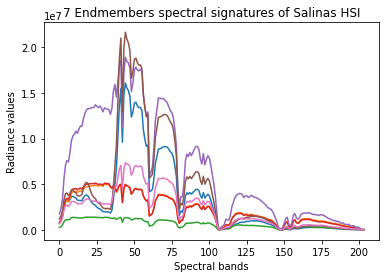

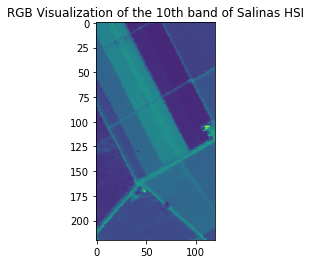

In [1]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

#### Question 1)

#### a)

Just to have a clear view of the parameters I am dealing with.

In [2]:
ground_truth

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar  1 23:21:46 2021',
 '__version__': '1.0',
 '__globals__': [],
 'salinas_gt': array([[0, 0, 0, ..., 0, 0, 0],
        [6, 6, 6, ..., 0, 0, 0],
        [6, 6, 6, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
ends

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar 01 22:07:30 2021',
 '__version__': '1.0',
 '__globals__': [],
 'salinas_endmembers': array([[ 859449,  760400,  269779, ..., 1766174, 1236288,  693400],
        [1085519,  987850,  346869, ..., 2314448, 1540378,  901617],
        [1537041, 1438887,  522332, ..., 3313375, 2057140, 1282030],
        ...,
        [  10865,   95408,   23453, ...,  125586,   16963,   34600],
        [   4222,   33340,    8098, ...,   43662,    6328,   11967],
        [   6201,   52982,   12739, ...,   69644,    9434,   19435]])}

In [4]:
np.shape(endmembers)

(204, 7)

In [5]:
len(endmembers[203])

7

In [6]:
np.shape(labels)        # ground truth

(220, 120)

I will reshape the HSI so that I can have all pixels in a single array (same to labels).

In [7]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
new_labels = labels.reshape((np.shape(HSI)[0]*np.shape(HSI)[1],1))     # 220x120

Checking the changes I have made:

In [9]:
np.shape(new_labels)

(26400, 1)

In [10]:
new_labels[119]

array([0], dtype=uint8)

In [11]:
new_labels[120]

array([6], dtype=uint8)

Each pixel consists of 204 spectral bands.

In [12]:
np.shape(HSI)

(220, 120, 204)

In [13]:
total_pixels = np.shape(HSI)[0]*np.shape(HSI)[1]   # 220x120
total_bands = np.shape(HSI)[2]                     # 204

new_HSI = HSI.reshape((total_pixels, total_bands))

Checking the alterations I have made:

In [14]:
np.shape(new_HSI)

(26400, 204)

In [15]:
new_HSI

array([[369, 579, 866, ...,  31,   9,  15],
       [369, 495, 735, ...,  33,  13,  15],
       [369, 495, 866, ...,  33,  11,  19],
       ...,
       [368, 485, 610, ...,  32,  13,  19],
       [368, 568, 676, ...,  42,  20,  21],
       [297, 568, 610, ...,  38,  13,  21]], dtype=int16)

##### Practically I am going to run a linear model per pixel with non-zero label. (could also be 26400 linear models in total)

##### a) Least Squares Method:

In [16]:
endmembers

array([[ 859449,  760400,  269779, ..., 1766174, 1236288,  693400],
       [1085519,  987850,  346869, ..., 2314448, 1540378,  901617],
       [1537041, 1438887,  522332, ..., 3313375, 2057140, 1282030],
       ...,
       [  10865,   95408,   23453, ...,  125586,   16963,   34600],
       [   4222,   33340,    8098, ...,   43662,    6328,   11967],
       [   6201,   52982,   12739, ...,   69644,    9434,   19435]])

In [17]:
materials = ["Grapes", "Broccoli", "Fallow 1", "Fallow 2", "Fallow 3", "Stuble", "Celery"]   # list with main signatures

In [30]:
theta_est_LS = np.ones((total_pixels, len(materials)))

for i in range(total_pixels):
    if new_labels[i]!=0:
        Y = new_HSI[i, :]         # practically an enumeration of all 26400 pixels starting row by row
        #theta_est_LS[i] = np.dot(np.linalg.inv(np.dot(endmembers.T, endmembers)), np.dot(endmembers.T, Y.T))         # Y-> 24600x1
        theta_est_LS[i] = (np.linalg.inv(np.dot(endmembers.T, endmembers))).dot(endmembers.T).dot(Y.T)     # theta_est=inv(Xt*X)*(Xt*Y)    (X=endmembers  204x7) (theta_est 24600x7) (new_HSI 24600x204)

In [41]:
# theta_est has changed, actually that many elements have changed # please ignore this, it's for me
sum(theta_est_LS==1)

array([9471, 9471, 9471, 9471, 9471, 9471, 9471])

In [32]:
theta_est_LS[875]       # theta_est for pixel number 876

array([  737.88251522,    62.43125874,  -371.48431229, -1655.98233324,
        1072.30592888,  -962.23040486,   232.78329029])

In [33]:
# code to show all arrays WITHOUT TRUNCATION
#import sys
#np.set_printoptions(threshold=sys.maxsize)

Defining functions to use in the performance of the questions:

In [34]:
np.shape(theta_est_LS)

(26400, 7)

In [35]:
def abundance_map(array_entry):
    for i in range(len(materials)):
        fig = plt.figure(figsize=(4,4))
        theta_estimate = array_entry[:,i].reshape((np.shape(HSI)[0], np.shape(HSI)[1]))
        plt.imshow(theta_estimate)
        plt.title("Material {}".format(materials[i]))

In [36]:
def reconstruction_error(X_theta):
    errors_list = []
    for i in range(total_pixels):
        if new_labels[i]!=0:
            error = new_HSI[i,:] - X_theta[i,:]
            errors_list.append(np.linalg.norm(error)**2)         
    mean_error = np.mean(errors_list)
    return mean_error

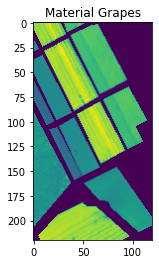

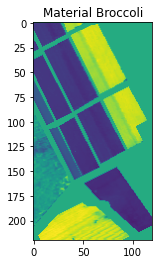

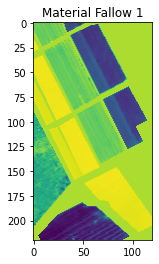

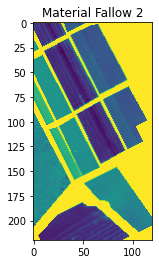

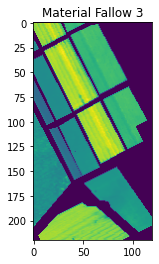

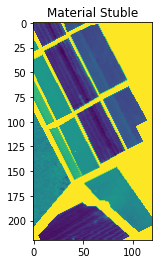

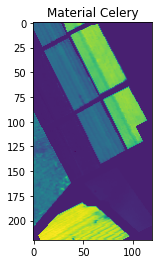

In [37]:
abundance_map(theta_est_LS)

In [38]:
np.shape(endmembers.dot(theta_est_LS.T).T)

(26400, 204)

In [39]:
np.shape(new_HSI)

(26400, 204)

In [40]:
print("The reconstruction error is: {}".format(reconstruction_error(endmembers.dot(theta_est_LS.T).T)))

The reconstruction error is: 1.7736299590314864e+21


#### b)

##### Least Squares imposing the sum-to-one constraint:

In [29]:
def a_function(theta, X, Y):
    return np.linalg.norm(np.dot(X,theta)-Y)

In [30]:
from scipy.optimize import nnls
from scipy.optimize import minimize

In [91]:
theta_est_sum1=np.zeros((total_pixels, len(materials)))
first_nnls,second_nnls=nnls(endmembers, new_HSI[i, :])
for i in range(total_pixels):
    if new_labels[i]!=0:
        theta_est_sum1[i] = minimize(a_function, x0=first_nnls, args=(endmembers, new_HSI[i, :]), method='SLSQP', constraints={'type':'eq','fun': lambda x: np.sum(x)-1}).x
# initial x0 is mandatory, so I use the solution of the Non-Negative Least Squares method
# eq = equality constraint
# a_function = objective function to minimize with method SLSQP
# args = arguments to be passes to the objective function (a_function)
# Sequential Least SQuares Programming minimizes a function of several variables with any combination of bounds, equality and inequality constraints.
# constaint=fun: function defining the constraint
# nnls()--> solves argmin_x || Ax - b ||_2 for x>=0 and returns solution vector and the residual || Ax-b ||_2

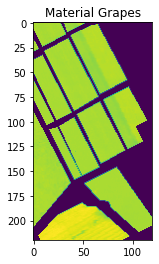

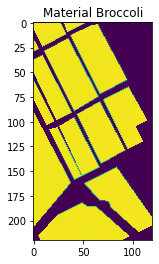

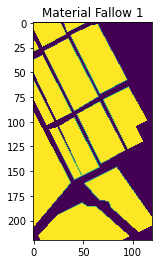

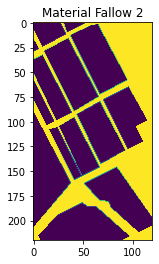

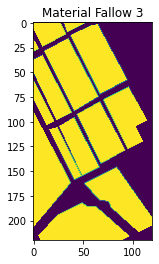

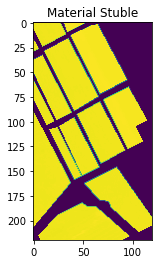

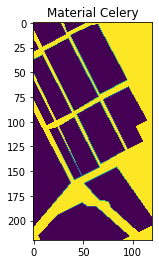

In [92]:
abundance_map(theta_est_sum1)

In [93]:
print("The reconstruction error is: {}".format(reconstruction_error(endmembers.dot(theta_est_sum1.T).T)))

The reconstruction error is: 27716914705.150826


#### c)

##### Least Squares imposing the non-negativity constraint on the entires of θ:


In [71]:
theta_est_nnls= np.zeros((total_pixels, len(materials)))
for i in range(total_pixels):
    if new_labels[i]!=0:
        first_nnls, second_nnls=nnls(endmembers,new_HSI[i,:])
        theta_est_nnls[i]= first_nnls

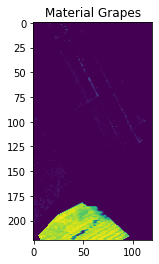

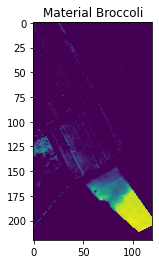

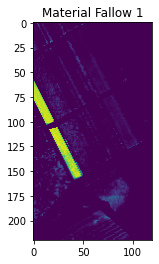

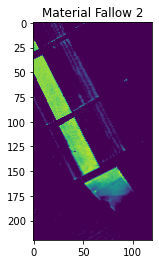

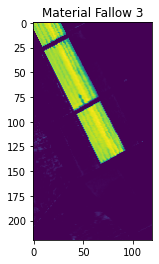

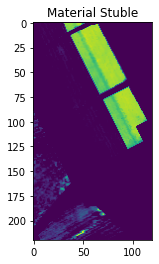

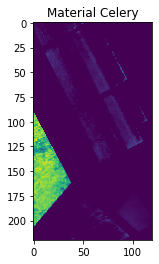

In [72]:
abundance_map(theta_est_nnls)

In [73]:
theta_est_nnls[666]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00029008, 0.        ])

In [74]:
print("The reconstruction error is: {}".format(reconstruction_error(endmembers.dot(theta_est_nnls.T).T)))

The reconstruction error is: 156104.18220644674


#### d)

##### Least Squares imposing both non-negativity and sum-to-one on the entries of θ:

In [80]:
import math
import sys

In [81]:
theta_est_sum1_and_nnls=np.zeros((total_pixels, len(materials)))
first_nnls,second_nnls=nnls(endmembers, new_HSI[i, :])
for i in range(total_pixels):
    if new_labels[i]!=0:
        theta_est_sum1_and_nnls[i]=minimize(a_function,x0=first_nnls,args=(endmembers, new_HSI[i, :]),method='SLSQP',constraints={'type':'eq','fun':lambda x:np.sum(x)-1},bounds=[(0., sys.float_info.max) for theta in first_nnls]).x
# (0,math.inf) but this is not the same

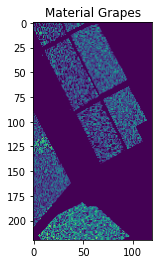

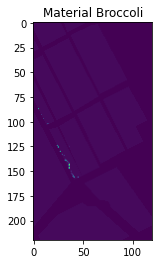

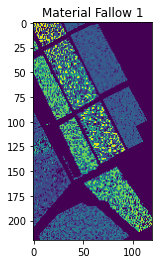

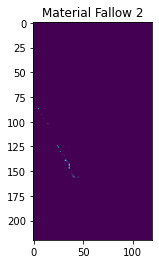

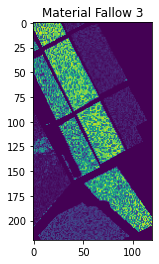

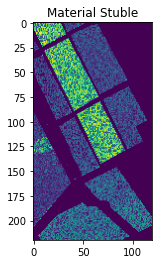

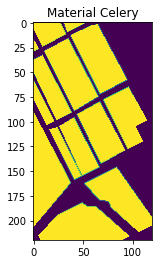

In [82]:
abundance_map(theta_est_sum1_and_nnls)

In [83]:
print("The reconstruction error is: {}".format(reconstruction_error(endmembers.dot(theta_est_sum1_and_nnls.T).T)))

The reconstruction error is: 1.2016321072264438e+17


#### e)

##### Lasso with imposed sparsity on θ via l1 norm minimization:

In [84]:
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings("ignore")

In [88]:
theta_Lasso =np.zeros((total_pixels,len(materials)))
for i in range(total_pixels):
    if new_labels[i]!=0:
        clf=Lasso(alpha=0.01,fit_intercept=False,positive=True, max_iter=100000)  # maybe add max_iter  # we want the coefficients to be positive
        clf.fit(endmembers,new_HSI[i,:])
        theta_Lasso[i]=clf.coef_

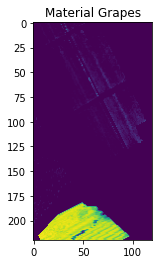

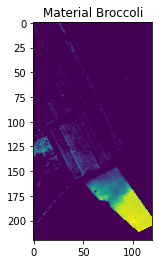

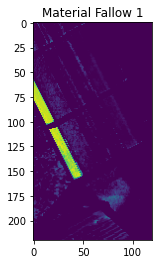

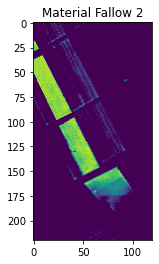

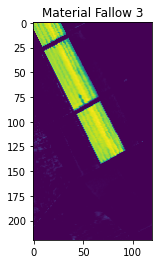

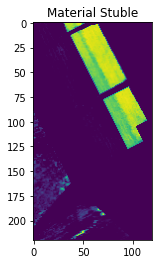

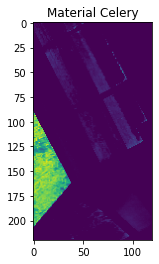

In [89]:
abundance_map(theta_Lasso)

In [90]:
print("The reconstruction error is: {}".format(reconstruction_error(endmembers.dot(theta_Lasso.T).T)))

The reconstruction error is: 157446.9458061325


#### Comparing the results:

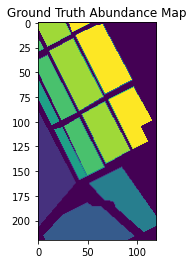

In [51]:
fig = plt.figure(figsize=(4,4))
plt.imshow(labels)
plt.title("Ground Truth Abundance Map")
plt.show()

Abundance Maps: Firstly, ideally the 7 abundance maps created by each different method applied would represent fully a different class of the endmembers each, thus we would like the 7 abundance maps combined to be similar to the ground truth one, but different from one another (7 maps different from one another).
The aforementioned argument is best depicted in the Lasso model method's abundance maps, therefore it seems like the Lasso method is the best that has been applied (notice also that the LS method with the non-negativity constraint does not seem to look bad either compared to the rest of the methods, they are actually similar, however from my perspective I think Lasso's maps look "cleaner").

Reconstruction Errors: It's evident that methods a), b) and d) have quite large reconstruction errors. On the contrary methods d) Lasso model c) Least Squares with the non-negativity constraint for θ have significantly lower reconstruction errors with the latter having the lowest only by an inch. From our general results, we can deduce that neither the abundance maps nor the errors should separately be considered to draw conclusions about the best fitting method. However, a combination of both seems to be more reasonable. In our case, the Lasso model as well as the LS non-negative model prove to be similarly appropriate for the data under study.

#### Question 2)

#### a)

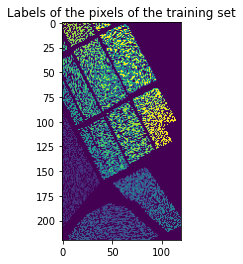

In [17]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [19]:
Training_Set

array([[0, 0, 0, ..., 0, 0, 0],
       [6, 6, 0, ..., 0, 0, 0],
       [6, 0, 6, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [20]:
np.shape(Training_Set)

(220, 120)

In [21]:
Test_Set

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 6, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [22]:
np.shape(Test_Set)

(220, 120)

In [23]:
Operational_Set

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 6, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [24]:
np.shape(Operational_Set)

(220, 120)

Again, I am going to "flatten" the data sets, in order to fit them in the classifiers (with new_HSI).

In [25]:
new_Training_Set=Training_Set.reshape((total_pixels,1))     # all 3 sets are now also 26400x1
new_Test_Set=Test_Set.reshape((total_pixels,1))
new_Operational_Set=Operational_Set.reshape((total_pixels,1))

In [26]:
np.shape(new_Training_Set)

(26400, 1)

Now, I also want choose the non-zero pixels. Thus:

In [27]:
X_train=[]
Y_train=[]

for i in range(total_pixels):
    if new_Training_Set[i]!=0:
        X_train.append(new_HSI[i,:])
        Y_train.append(new_Training_Set[i])

In [28]:
X_train[:2]

[array([ 441,  558,  787, 1344, 1706, 1830, 1781, 2022, 2343, 2473, 2491,
        2565, 2492, 2617, 2685, 2672, 2860, 2983, 3069, 3107, 3115, 3139,
        3151, 3170, 3239, 3188, 3140, 3209, 3168, 3082, 3190, 3179, 3145,
        3138, 2998, 3130, 3554, 3725, 3383, 3757, 4161, 4297, 2603, 3960,
        4369, 4269, 4221, 4135, 3532, 3735, 4074, 4161, 4071, 4047, 4094,
        4041, 3453, 3148, 2948, 3040, 1413, 1503, 1637, 2134, 2840, 3108,
        3422, 3427, 3403, 3399, 3381, 3333, 3288, 3184, 3089, 3042, 2912,
        2614, 2212, 1096,  635,  877,  877, 1206, 1799, 1998, 1925, 2046,
        1952, 2046, 2131, 2197, 2188, 2127, 1863, 1725, 1998, 1722, 1857,
        1958, 1898, 1699, 1470, 1223,  899,  477,   34,   41,   87,  106,
         157,  290,  277,  267,  386,  621,  743,  861,  920,  955,  974,
         974,  941,  867,  906,  914,  863,  892,  922,  894,  866,  868,
         843,  826,  797,  762,  728,  691,  642,  597,  571,  557,  503,
         424,  329,  220,   86,   30, 

Now, the same for the Test Set and the Operational Set:

In [29]:
X_test=[]
Y_test=[]

for i in range(total_pixels):
    if new_Test_Set[i]!=0:
        X_test.append(new_HSI[i,:])
        Y_test.append(new_Test_Set[i])

In [30]:
X_operational=[]
Y_operational=[]

for i in range(total_pixels):
    if new_Operational_Set[i]!=0:
        X_operational.append(new_HSI[i,:])
        Y_operational.append(new_Operational_Set[i])

Now, I am going to apply the data to the classifiers:

#### i) Naive Bayes Classifier

In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
CV_score_NB = cross_val_score(GaussianNB(),X_train,Y_train,cv=10)
error_NB = 1-CV_score_NB
mean_NB = np.mean(error_NB)
std_dev_NB = np.std(error_NB)

In [34]:
print('So, the estimated validation error is: {}.'.format(mean_NB))
print('And the the standard deviation is: {}.'.format(std_dev_NB))

So, the estimated validation error is: 0.026223969454143535.
And the the standard deviation is: 0.016023209106526503.


In [35]:
model_NB = GaussianNB()
model_NB.fit(X_train,Y_train)
preds_NB = model_NB.predict(X_test)     # Naive Bayes predictions

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
confusion_NB = confusion_matrix(Y_test,preds_NB)
print(confusion_NB)    # confusion matrix of Naive Bayes Classifier

[[545   0   0   0   0   0   3]
 [  5 512   0   0   0   0   0]
 [  0   0 470   0  42   0   0]
 [  0   0   0 210   4   0   0]
 [  0   0  12   4 547   0   0]
 [  1   0   2   0   0 995   0]
 [  6   0   0   0   0   0 874]]


In [38]:
# to calculate the success rate of the classifier I sum the diagonal elements and divide by the sum of the elements of the confusion matrix
success_NB = np.trace(confusion_NB)/np.sum(confusion_NB)       # trace()->sums the diagonal elements and sum()->all the elements of the matrix
print('So the the Classifier\'s success rate is: {}.'.format(success_NB))

So the the Classifier's success rate is: 0.9813327032136105.


#### ii) Minimum Euclidean Distance Classifier

In [66]:
reshaped_training_set = Training_Set.reshape((total_pixels,1))

In [67]:
X_TRAIN = np.empty((0,204))
Y_TRAIN =  np.empty((0,1))

for i in range(total_pixels):
    if reshaped_training_set[i]!=0:
        X_TRAIN = np.append(X_TRAIN, [new_HSI[i,:]],axis=0) 
        Y_TRAIN = np.append(Y_TRAIN, [reshaped_training_set[i]],axis=0) 

In [68]:
from sklearn.model_selection import KFold

In [69]:
def calculate_distance(minimum_distance, distance) :
    if minimum_distance== distance[0]:
        return 1
    elif minimum_distance== distance[1]:
        return 2
    elif minimum_distance== distance[2]:
        return 3
    elif minimum_distance== distance[3]:
        return 4
    elif minimum_distance== distance[4]:
        return 5
    elif minimum_distance== distance[5]:
        return 6
    else:
        return 7

In [71]:
def compute_means_per_class(X,y):
    
    X_per_class = np.empty((0,204))
    x_means = np.empty((0,204)) 
    for label in range(1,8):
        for i in range(X.shape[0]):
            if y[i]== label:
                X_per_class = np.append(X_per_class, [X[i]], axis = 0)
        mean_per_class = np.mean(X_per_class, axis = 0)
        x_means = np.append(x_means, [mean_per_class], axis = 0)
        X_per_class = np.empty((0,204))
        
    return x_means

In [73]:
errors_cv = np.empty((0,1))
for i, j in KFold(n_splits=10).split(X_TRAIN, Y_TRAIN):  # cross validation
    X_train_cv=X_TRAIN[i]
    y_train_cv=Y_TRAIN[i]
    X_test_cv=X_TRAIN[j]
    y_test_cv=Y_TRAIN[j]
    #print(len(y_test_cv))
    Cs = X_test_cv.shape[0]
    #print(X_test)
    class_means = compute_means_per_class(X_train_cv, y_train_cv)
    
    MED_pred = np.empty((0,1))
    dist = np.empty((Cs,7))
    for i in range(Cs):
        for j in range(7):
            dist[i,j] = np.linalg.norm(X_test_cv[i] - class_means[j])**2
            min_dist = np.min(dist[i,:])
        MED_pred = np.append(MED_pred,calculate_distance(min_dist, dist[i]))
    #print(len(MED_pred))
    
        count_errors = 0
    for k in range(Cs):
        #print(type(y_test_cv[k]))
        #print(MED_pred[k])
        diff = y_test_cv[k] - MED_pred[k]
        if diff == 0:
            continue
        else:
            count_errors +=1
            
    prob_error=count_errors/Cs
    errors_cv=np.append(errors_cv, prob_error)

In [74]:
MED_mean = np.mean(errors_cv)
MED_std = np.std(errors_cv)

print('The Minimum Euclidean distance classifier validation error is', MED_mean)
print('The Minimum Euclidean distance classifier standard deviation validation error is', MED_std)

The Minimum Euclidean distance classifier validation error is 0.05507548544299028
The Minimum Euclidean distance classifier standard deviation validation error is 0.076823601071471


In [77]:
reshaped_test_set = Test_Set.reshape((total_pixels,1))
X_TEST=np.empty((0,204))
Y_TEST=np.empty((0,1))

for i in range(total_pixels):
    if reshaped_test_set[i]!=0:
        X_TEST= np.append(X_TEST,[new_HSI[i,:]],axis=0) 
        Y_TEST = np.append(Y_TEST,[reshaped_test_set[i]],axis=0) 

In [78]:
MED_class_means = compute_means_per_class(X_TRAIN, Y_TRAIN)
D =  X_TEST.shape[0]  
med_pred2 = np.empty((0,1))  
dist = np.empty((D,7))
    
for i in range(D):
    for j in range(7):
        dist[i,j] = np.linalg.norm(X_TEST[i] - MED_class_means[j])**2
        min_dist = np.min(dist[i,:])
        
    med_pred2 = np.append(med_pred2,calculate_distance(min_dist, dist[i]))
        
MED_cm = confusion_matrix(Y_TEST, med_pred2)
print('Minimum Euclidean Distance classifier confusion matrix:')
print(MED_cm)

Minimum Euclidean Distance classifier confusion matrix:
[[536   0   4   0   1   0   7]
 [  2 484   0   0   0   0  31]
 [  0   0 417   0  95   0   0]
 [  0   0   0 212   2   0   0]
 [  0   0  16   4 543   0   0]
 [  0   0   6   0   0 992   0]
 [  5   0   0   0   0   0 875]]


In [79]:
# to calculate the success rate of the classifier I sum the diagonal elements and divide by the sum of the elements of the confusion matrix
success_Eu= np.trace(MED_cm)/np.sum(MED_cm)       # trace()->sums the diagonal elements and sum()->all the elements of the matrix
print('So the the Classifier\'s success rate is: {}.'.format(success_Eu))

So the the Classifier's success rate is: 0.9591209829867675.


#### iii) k-nearest Neighbor Classifier

In [80]:
from sklearn.neighbors import KNeighborsClassifier

In [81]:
CV_score_knn = cross_val_score(KNeighborsClassifier(n_neighbors=7),X_train,Y_train,cv=10)
error_knn = 1-CV_score_knn
mean_knn = np.mean(error_knn)
std_dev_knn = np.std(error_knn)

In [82]:
print('So, the estimated validation error is: {}.'.format(mean_knn))
print('And the the standard deviation is: {}.'.format(std_dev_knn))

So, the estimated validation error is: 0.010161995751937714.
And the the standard deviation is: 0.014136851235651886.


In [83]:
model_knn = KNeighborsClassifier(n_neighbors=7)
model_knn.fit(X_train,Y_train)
preds_knn = model_knn.predict(X_test)     # knn predictions

In [84]:
confusion_knn = confusion_matrix(Y_test,preds_knn)
print(confusion_knn)    # confusion matrix of knn classifier

[[547   0   0   0   0   0   1]
 [  0 516   0   0   0   0   1]
 [  0   0 510   0   2   0   0]
 [  0   0   0 214   0   0   0]
 [  0   0   8   1 552   2   0]
 [  0   0   0   0   0 998   0]
 [  2   0   0   0   0   0 878]]


In [85]:
# to calculate the success rate of the classifier I sum the diagonal elements and divide by the sum of the elements of the confusion matrix
success_knn = np.trace(confusion_knn)/np.sum(confusion_knn)       # trace()->sums the diagonal elements and sum()->all the elements of the matrix
print('So the the Classifier\'s success rate is: {}.'.format(success_knn))

So the the Classifier's success rate is: 0.9959829867674859.


#### iv) Bayesian Classifier

In [86]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [87]:
CV_score_QDA = cross_val_score(QuadraticDiscriminantAnalysis(),X_train,Y_train,cv=10)
error_QDA = 1-CV_score_QDA
mean_QDA = np.mean(error_QDA)
std_dev_QDA = np.std(error_QDA)

In [88]:
print('So, the estimated validation error is: {}.'.format(mean_QDA))
print('And the the standard deviation is: {}.'.format(std_dev_QDA))

So, the estimated validation error is: 0.03426123629218406.
And the the standard deviation is: 0.005850919532443715.


In [89]:
model_QDA = QuadraticDiscriminantAnalysis()
model_QDA.fit(X_train,Y_train)
preds_QDA = model_QDA.predict(X_test)     # Quadratic Discriminant Analysis predictions
# NOTE: I could also use LinearDiscriminantAnalysis. However the error is slightly higher, BUT in general the success rate slightly higher. (we don't know if the covariance matrices are equal per class)

In [90]:
confusion_QDA = confusion_matrix(Y_test,preds_QDA)
print(confusion_QDA)    # confusion matrix of QDA classifier

[[548   0   0   0   0   0   0]
 [  0 517   0   0   0   0   0]
 [  0   0 512   0   0   0   0]
 [  0   0   0 125  89   0   0]
 [  0   0   3   0 558   2   0]
 [  0   0   0   0   0 998   0]
 [  0   0   0   0   0   0 880]]


In [91]:
# to calculate the success rate of the classifier I sum the diagonal elements and divide by the sum of the elements of the confusion matrix
success_QDA = np.trace(confusion_QDA)/np.sum(confusion_QDA)       # trace()->sums the diagonal elements and sum()->all the elements of the matrix
print('So the the Classifier\'s success rate is: {}.'.format(success_QDA))

So the the Classifier's success rate is: 0.9777882797731569.


In [92]:
CV_score_LDA = cross_val_score(LinearDiscriminantAnalysis(),X_train,Y_train,cv=10)
error_LDA = 1-CV_score_LDA
mean_LDA = np.mean(error_LDA)
std_dev_LDA = np.std(error_LDA)

In [93]:
print('So, the estimated validation error is: {}.'.format(mean_LDA))
print('And the the standard deviation is: {}.'.format(std_dev_LDA))

So, the estimated validation error is: 0.004727434611380444.
And the the standard deviation is: 0.005910472605334186.


In [94]:
model_LDA = LinearDiscriminantAnalysis()
model_LDA.fit(X_train,Y_train)
preds_LDA = model_LDA.predict(X_test)     # Linear Discriminant Analysis predictions

In [95]:
confusion_LDA = confusion_matrix(Y_test,preds_LDA)
print(confusion_LDA)    # confusion matrix of LDA classifier

[[548   0   0   0   0   0   0]
 [  0 517   0   0   0   0   0]
 [  0   0 512   0   0   0   0]
 [  0   0   0 209   5   0   0]
 [  1   0   2   5 555   0   0]
 [  0   0   0   0   0 998   0]
 [  0   0   0   0   0   0 880]]


In [96]:
# to calculate the success rate of the classifier I sum the diagonal elements and divide by the sum of the elements of the confusion matrix
success_LDA = np.trace(confusion_LDA)/np.sum(confusion_LDA)       # trace()->sums the diagonal elements and sum()->all the elements of the matrix
print('So the the Classifier\'s success rate is: {}.'.format(success_LDA))

So the the Classifier's success rate is: 0.9969281663516069.


#### Comparing the results of the classifiers:

Comparing the confusion matrices of the applied classifiers, it is evident that the diagonal elements of the LDA (LinearDiscriminantAnalysis) Bayesian Classifier and the k-nearest Neighbor Classifier are clearly many more than those of the other classifiers. This, of course, means that the misclassified pixels are less in the two classifiers (lower non-diagonal elements-numbers). The success rates is also another indicator that these two classifiers (LDA and kNN) bring better results, since in their cases the success rates are ~0.996-0.997. It is worth to mention that in the case of LDA, 5 pixels of "Fallow 2" are misclassifed as "Fallow 3" and the same occurs for another 5 pixels inversed-they are misclassified as "Fallow 2" although they belong to "Fallow 3". In the case of kNN, the only non-diagonal number worth mentioning is 8, which represents 8 points that belong to "Fallow 3" and are misclassified as "Fallow 1". There rest classifiers show misclassifications that cannot be ignored.

#### Question 3)

The method of spectral unmixing, which was used in the first part of the project should ideally agree with the classificiation results. This means that through the decomposition of the spectral signature of each pixel, the results should ideally show the contributions of each material(endmember), which are (the materials) considered spectrally unique. Following these results, the classifiers should indicate similar results in their confusion matrices. For example, if the spectral unmixing showed great contribution of the "Celery" material, it would be expected from the classifier to show a high diagonal number of the Celery row in its confusion matrix. In our pixel data, it is worth mentioning that based on the best classifiers LDA and kNN, "Fallow 2" seems to have a small contribution and "Stuble", "Celery" have really big contributions. The rest of the materials have a similar contribution (they are more balanced).